# Relative Peak Intensities in 2D materials with STEM

In [164]:
%load_ext autoreload
%autoreload 2
from ase.build import mx2
from ase.io import read
import numpy as np

from tensorwaves.waves import ProbeWaves
from tensorwaves.potentials import Potential
from tensorwaves.detect import RingDetector
from tensorwaves.analyse import cluster_columns, plot_columns

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ase.visualize import view

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import/Create Atoms

In [ ]:
from ase.build import mx2


hbn = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

In [654]:
atoms = read('../data/graphene.traj')

#atoms[0].symbol = 'B'
#atoms[2].symbol = 'B'
#atoms[1].symbol = 'N'
#atoms[3].symbol = 'N'
atoms.cell[2,2]=2.5
atoms.center()

atoms *= (5,3,1)

atoms[15].symbol = 'Si'

#atoms[15].symbol = 'C'
#atoms[19].symbol = 'O'

view(atoms)

In [540]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19)
atoms *= (2,2,1)
atoms.cell[1,0] = 0
atoms.wrap()
atoms *= (2,2,1)
atoms.center(vacuum=1, axis=2)

atoms[36].symbol = 'Si'

## Classify Atomic Columns

(0.04507228195937829,
 12.254927718040623,
 0.11673383215147981,
 12.665801127706835)

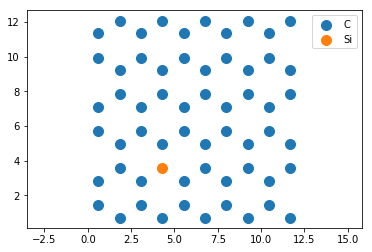

In [571]:
column_positions, labels, types = cluster_columns(atoms, tol=1e-2, longitudinal_ordering=False)

fig, ax = plt.subplots()
for i, label in enumerate(np.unique(labels)):
    ax.scatter(*column_positions[label == labels].T, label=types[i], s=100)

ax.legend()
ax.axis('equal')

## Simulate Column Positions

In [545]:
potential = Potential(atoms, tolerance=1e-3)

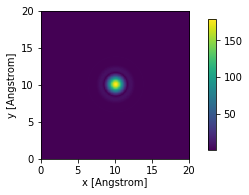

In [634]:
aberrations = {'C10': 0}

probe = ProbeWaves(energy=60e3, aperture_radius=.005, aperture_rolloff=.025, sampling=.05, 
                   extent=20, **aberrations)
probe.positions = (10,10)
probe.get_tensor().show()

In [635]:

def fwhm(intensity, extent):
    argmax = np.argmax(intensity)
    hm = intensity[argmax] / 2
    
    x = np.linspace(0, extent, len(intensity))
    x_min = x[np.argmin(np.abs(intensity[:argmax] - hm))]
    x_max = x[np.argmin(np.abs(intensity[argmax:] - hm)) + argmax]
    
    return x_max - x_min


In [636]:
i = probe.get_tensor().image().numpy()[0,200]



fwhm(i, 20)

#plt.plot(x,i)

1.2030075187969906

In [648]:
probe.clear_grid()
probe.sampling= .02

detector = RingDetector(inner=.058, outer=.2)

scan = probe.custom_scan(atoms, 2000, column_positions, detectors=detector)

Multislice [||||||||||||||||||||||||||||||||||||||||||||||||||] 4/4 


## Calculate Relative Intensities

In [649]:
intensities = scan.numpy()

column_intensities = {}
for i, label in enumerate(np.unique(labels)):
    column_intensities[types[i]] = intensities[label == labels]

column_intensities

{'C': array([0.00084887, 0.00084798, 0.00084876, 0.00084787, 0.00084874,
        0.00085261, 0.00084886, 0.00084797, 0.00084889, 0.00084877,
        0.00084788, 0.00085277, 0.00084869, 0.00084779, 0.00085267,
        0.00084879, 0.00084888, 0.00085275, 0.00084895, 0.00085282,
        0.00085278, 0.00085288, 0.00084776, 0.00085265, 0.00084799,
        0.00085276, 0.00086423, 0.00085305, 0.00085297, 0.00085288,
        0.00084815, 0.00085296, 0.00085257, 0.00085269, 0.00084804,
        0.00084781, 0.00084791, 0.00084813, 0.00084798, 0.0008482 ,
        0.00084817, 0.00084891, 0.00085276, 0.00084804, 0.00084891,
        0.00084903, 0.00085282, 0.00084845, 0.00086572, 0.00084836,
        0.00086562, 0.00084797, 0.00084884, 0.00085281, 0.00084909,
        0.00085278, 0.00085286, 0.00084883, 0.0008489 ], dtype=float32),
 'Si': array([0.00399664], dtype=float32)}

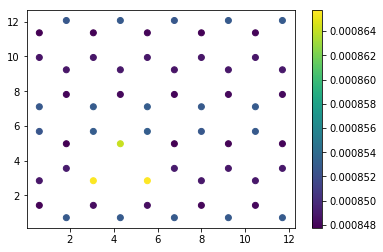

In [650]:
plt.scatter(*column_positions[labels==0].T, c=intensities[labels==0])
plt.colorbar()

In [651]:
ratios = {}
for combination in combinations(types, 2):
    intensity_1 = np.mean(column_intensities[combination[0]])
    intensity_2 = np.mean(column_intensities[combination[1]])
    
    order = np.argsort((intensity_1, intensity_2))
    ratio = (intensity_1, intensity_2)[order[0]] / (intensity_1, intensity_2)[order[1]]
    ratios['/'.join([combination[i] for i in order])] = ratio

ratios

{'C/Si': 0.21286742}

In [652]:
from scipy.optimize import minimize_scalar
from ase.symbols import string2symbols, symbols2numbers

power_law = {}
for ratio_name, ratio in ratios.items():
    Z_1 = sum(symbols2numbers(string2symbols(ratio_name.split('/')[0])))
    Z_2 = sum(symbols2numbers(string2symbols(ratio_name.split('/')[1])))
    
    eq = lambda n: ((Z_1 / Z_2) ** n - ratio) ** 2
    
    power_law[ratio_name] = minimize_scalar(eq).x

power_law

{'C/Si': 1.8259053790972526}

In [653]:
minimum_intensity = min([np.mean(values) for values in column_intensities.values()])

print('\t', 'mean', '\t', '\t', 'st.d.')
for key, value in column_intensities.items():
    print('{} \t {:.6f} \t {:.3e}'.format(key, np.mean(value) / minimum_intensity, np.std(value)))

print()
print('\t', 'ratios')
for key, value in ratios.items():
    print(key, '\t', value)

print()
print('\t', 'n')
for key, value in power_law.items():
    print(key, '\t', value)

	 mean 	 	 st.d.
C 	 1.000000 	 3.934e-06
Si 	 4.697760 	 0.000e+00

	 ratios
C/Si 	 0.21286742

	 n
C/Si 	 1.8259053790972526
